<a href="https://colab.research.google.com/github/NINGTANG1124/UPF-HFI/blob/main/%20notebooks/2-modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# connect to googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- 0. 导入库 ---
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# 用于倾向评分估计 & 平衡表
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances


In [ ]:
# 读取
survey_df = pd.read_excel( "/content/drive/MyDrive/UPF-HFI/Model/outcome/survey_with_HFI.xlsx")
df_upf    = pd.read_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_percent.xlsx")

In [ ]:
# ==== 先检查 ====
issues = []

# 检查关键列
for col in ["UserID_clean", "HFI_binary", "HFI_raw_score"]:
    if col not in survey_df.columns:
        issues.append(f"survey 缺少 {col}")

for col in ["UserID_clean", "weighted_upf_percent"]:
    if col not in df_upf.columns:
        issues.append(f"upf 缺少 {col}")

# 检查 ID 是否有缺失/重复
for name, df in [("survey", survey_df), ("upf", df_upf)]:
    n_na = df["UserID_clean"].isna().sum()
    n_dup = df["UserID_clean"].duplicated().sum()
    if n_na:  issues.append(f"{name} 的 UserID_clean 有 {n_na} 个缺失")
    if n_dup: issues.append(f"{name} 的 UserID_clean 有 {n_dup} 个重复")

# 检查 upf_percent 是否数值
bad_upf = pd.to_numeric(df_upf["weighted_upf_percent"], errors="coerce").isna().sum()
if bad_upf:
    issues.append(f"weighted_upf_percent 有 {bad_upf} 个非数值/缺失")

# 打印检查结果
if issues:
    print("检查发现以下问题：")
    for i, msg in enumerate(issues, 1):
        print(f"{i}. {msg}")
else:
    print("没有发现问题，可以直接处理")


没有发现问题，可以直接处理


In [ ]:
# ==== 检查关键变量缺失情况 ====
check_cols = ["HFI_binary", "weighted_upf_percent"]
missing_info = {}

for col in check_cols:
    if col not in survey_df.columns and col not in df_upf.columns:
        print(f"数据中找不到列: {col}")
        continue

    if col in survey_df.columns:
        n_miss = survey_df[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 survey_df 中缺失 {n_miss} 行")

    if col in df_upf.columns:
        n_miss = df_upf[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 upf_df 中缺失 {n_miss} 行")

# ==== 判断是否需要处理 ====
if all(v == 0 for v in missing_info.values()):
    print("两列都没有缺失，可以直接进入合并/建模")
else:
    print("存在缺失，需要处理后再合并")


HFI_binary 在 survey_df 中缺失 18 行
weighted_upf_percent 在 upf_df 中缺失 0 行
存在缺失，需要处理后再合并


In [ ]:
# 1. 合并 survey 和 upf
df_model = pd.merge(survey_df, df_upf, on="UserID_clean", how="inner")

# 2. 删掉 HFI_binary 缺失的
df_model = df_model.dropna(subset=["HFI_binary"])

print("合并后样本量：", len(df_model))


合并后样本量： 308


In [ ]:
# 查看族裔变量的原始分布
df_model["ethn_participant"].value_counts(dropna=False)


,count
ethn_participant,
1,156
3,76
7,33
2,13
4,10
5,8
6,6
8,4
9,2


In [ ]:
# 根据 BiB 文献做的三类
df_model["ethnicity3"] = df_model["ethn_participant"].replace({
    1: "White British",
    3: "Pakistani"
})
df_model["ethnicity3"] = df_model["ethnicity3"].where(
    df_model["ethnicity3"].isin(["White British", "Pakistani"]), "Other"
)

df_model["ethnicity3"].value_counts()


,count
ethnicity3,
White British,156
Other,76
Pakistani,76


In [ ]:
# 检查主要分析变量缺失
main_vars = [
    "HFI_binary", "weighted_upf_percent",
    "gender_participant", "age_participant", "ethnicity3"
]

missing_info = {}
for col in main_vars:
    n_miss = df_model[col].isna().sum()
    missing_info[col] = n_miss

df_main = df_model[main_vars].dropna().copy()
print("主分析样本量:", len(df_main))

主分析样本量: 308


# 建模

## 0) 预备：映射族裔（WB / PK / Mixed），构建两套数据集

In [42]:
import numpy as np
import pandas as pd

# ===== 0.1 映射族裔：1=WB, 3=Pakistani, 7=Mixed，其余=Other =====
df = df_model.copy()
eth_map = {1:"White British", 3:"Pakistani", 7:"Mixed"}
df["ethnicity3"] = df["ethn_participant"].map(eth_map).fillna("Other")

# ===== 0.2 仅保留主族群（WB/PK/Mixed），拆两套数据集 =====
core_vars = ["HFI_binary","weighted_upf_percent","age_participant","gender_participant","ethnicity3"]
ses_vars  = core_vars + ["income","employ"]

df_core = (df.loc[df["ethnicity3"].isin(["White British","Pakistani","Mixed"]), core_vars]
             .dropna().copy())           # 主分析（不含 SES）
df_ses  = (df.loc[df["ethnicity3"].isin(["White British","Pakistani","Mixed"]), ses_vars]
             .dropna().copy())           # SES 解释性（含 SES）

print("Core n=", len(df_core), df_core["ethnicity3"].value_counts().to_dict())
print("SES  n=", len(df_ses),  df_ses["ethnicity3"].value_counts().to_dict())


Core n= 265 {'White British': 156, 'Pakistani': 76, 'Mixed': 33}
SES  n= 261 {'White British': 154, 'Pakistani': 75, 'Mixed': 32}


## 1) 工具函数：PS 加权（稳定化权重）、SMD 平衡表、结果表拼接

In [43]:
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf

def fit_ps_and_sw(df_in, X_cols, treat_col="HFI_binary"):
    X = pd.get_dummies(df_in[X_cols], drop_first=True)
    y = df_in[treat_col].astype(int)
    m = LogisticRegression(max_iter=1000).fit(X,y)
    ps = m.predict_proba(X)[:,1]
    p1 = y.mean()
    sw = np.where(y==1, p1/ps, (1-p1)/(1-ps))
    return sw, ps

def smd_binary(x, w):
    # 标准化差异（加权前后）
    treat = (x.index if isinstance(x, pd.Series) else x).astype(bool)
    m1 = np.average(x[treat==1], weights=w[treat==1]) if w is not None else x[treat==1].mean()
    m0 = np.average(x[treat==0], weights=w[treat==0]) if w is not None else x[treat==0].mean()
    v  = np.var(x, ddof=1)
    return (m1-m0)/np.sqrt(v+1e-9)

def balance_table(df_in, covs, treat_col="HFI_binary", sw=None):
    out = []
    t = df_in[treat_col].astype(int)
    w = sw if sw is not None else np.ones(len(df_in))
    for c in covs:
        x = pd.get_dummies(df_in[c], drop_first=False) if df_in[c].dtype=='O' else df_in[[c]]
        if isinstance(x, pd.DataFrame):
            for k in x.columns:
                out.append([f"{c}={k}",
                            smd_binary(x[k], np.ones(len(x))),
                            smd_binary(x[k], w)])
        else:
            out.append([c, smd_binary(x.squeeze(), np.ones(len(x))),
                           smd_binary(x.squeeze(), w)])
    tab = pd.DataFrame(out, columns=["Covariate","SMD (unweighted)","SMD (PSW)"])
    return tab

def pretty_ci(est, ci):
    return f"{est:.2f} ({ci[0]:.2f}, {ci[1]:.2f})"


# 2) Core-A：主效应（PSW + HC3）与 OLS 对照

In [44]:
# PS：人口学（Age + Gender + Ethnicity3）
sw_core, ps = fit_ps_and_sw(df_core, ["age_participant","gender_participant","ethnicity3"])

# WLS(+HC3) 主效应
m_coreA = smf.wls("weighted_upf_percent ~ HFI_binary",
                  data=df_core, weights=sw_core).fit(cov_type="HC3")
d_coreA = m_coreA.params["HFI_binary"]
ci_coreA = m_coreA.conf_int().loc["HFI_binary"].tolist()
print("[Core-A PSW] Δ =", pretty_ci(d_coreA, ci_coreA))

# 对照：OLS(+HC3)（显式加人口学）
m_ols = smf.ols("weighted_upf_percent ~ HFI_binary + age_participant + C(gender_participant) + C(ethnicity3)",
                data=df_core).fit(cov_type="HC3")
d_ols = m_ols.params["HFI_binary"]; ci_ols = m_ols.conf_int().loc["HFI_binary"].tolist()
print("[OLS adj]   Δ =", pretty_ci(d_ols, ci_ols))

# 平衡表（可选，放 Table 1）
bal = balance_table(df_core, ["age_participant","gender_participant","ethnicity3"],
                    sw=sw_core)
bal


[Core-A PSW] Δ = 1.83 (-1.45, 5.10)
[OLS adj]   Δ = 1.76 (-1.50, 5.03)


,Covariate,SMD (unweighted),SMD (PSW)
0,age_participant=age_participant,-0.406838,-0.417795
1,gender_participant=gender_participant,-0.983164,-0.981895
2,ethnicity3=Mixed,0.377863,0.374786
3,ethnicity3=Pakistani,0.635326,0.632527
4,ethnicity3=White British,-0.837475,-0.832838


# 3) Core-B：唯一交互（HFI × Ethnicity3），并输出族群内 Δ（pp）+ 95%CI

In [45]:
# 交互模型（PSW 权重）
m_coreB = smf.wls("weighted_upf_percent ~ HFI_binary * C(ethnicity3)",
                  data=df_core, weights=sw_core).fit(cov_type="HC3")
print(m_coreB.summary().tables[1])

# 族群内 Δ
rows = []
for g in ["White British","Pakistani","Mixed"]:
    sub = df_core[df_core["ethnicity3"]==g]
    swg = sw_core[df_core["ethnicity3"]==g]
    mm = smf.wls("weighted_upf_percent ~ HFI_binary", data=sub, weights=swg).fit(cov_type="HC3")
    ci = mm.conf_int().loc["HFI_binary"].tolist()
    rows.append([g, mm.params["HFI_binary"], ci[0], ci[1]])
coreB_by_eth = pd.DataFrame(rows, columns=["Ethnicity","Δ (pp)","95% CI lower","95% CI upper"]).round(2)
coreB_by_eth


                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    66.1332      2.944     22.466      0.000      60.364      71.903
C(ethnicity3)[T.Pakistani]                   -1.3195      3.502     -0.377      0.706      -8.184       5.545
C(ethnicity3)[T.White British]                5.7143      3.138      1.821      0.069      -0.436      11.864
HFI_binary                                    8.2725      4.933      1.677      0.094      -1.396      17.941
HFI_binary:C(ethnicity3)[T.Pakistani]        -6.9849      5.687     -1.228      0.219     -18.132       4.162
HFI_binary:C(ethnicity3)[T.White British]    -7.5063      5.408     -1.388      0.165     -18.106       3.094


,Ethnicity,Δ (pp),95% CI lower,95% CI upper
0,White British,0.77,-3.58,5.11
1,Pakistani,1.29,-4.26,6.84
2,Mixed,8.27,-1.40,17.94


# 4) Sens-SES：把 income+employ 放进 PS（解释性衰减）

In [46]:
# SES 版 PS
sw_ses, _ = fit_ps_and_sw(df_ses, ["age_participant","gender_participant","ethnicity3","income","employ"])

m_ses = smf.wls("weighted_upf_percent ~ HFI_binary",
                data=df_ses, weights=sw_ses).fit(cov_type="HC3")
d_ses = m_ses.params["HFI_binary"]; ci_ses = m_ses.conf_int().loc["HFI_binary"].tolist()
print("[SES-PSW]    Δ =", pretty_ci(d_ses, ci_ses))

atten = (d_coreA - d_ses)/d_coreA*100 if d_coreA!=0 else np.nan
print(f"Attenuation from Core-A to SES: {atten:.1f}%")


[SES-PSW]    Δ = 3.42 (-0.67, 7.50)
Attenuation from Core-A to SES: -86.8%


# 5) 稳健性 1：HFI 三分类趋势（线性趋势检验，PSW 后）

In [47]:
# 假设你已有三分类列：HFI_3cat（0/1/2），否则先据量表生成
# 这里只示范：把 binary 升级为三分类 = binary （0,1）+ 随机示意，不要照抄
# df_core["HFI_3cat"] = ...

m_trend = smf.wls("weighted_upf_percent ~ HFI_binary", data=df_core, weights=sw_core).fit(cov_type="HC3")
# 若有 HFI_3cat，可跑： ~ C(HFI_3cat) 并检验线性趋势（对类别编码成 0/1/2 连续）
# trend_m = smf.wls("weighted_upf_percent ~ HFI_3cat", data=df_core, weights=sw_core).fit(cov_type="HC3")
# print(trend_m.summary())


# 6) 稳健性 2：分位数回归（中位数）

In [48]:
import statsmodels.api as sm
# 分位数回归在 PSW 上没现成“加权+HC3”，这里跑未加权的稳健性版本
qr = sm.QuantReg(df_core["weighted_upf_percent"], sm.add_constant(df_core[["HFI_binary","age_participant"]]))
qr_m = qr.fit(q=0.5)
qr_m.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                          QuantReg Regression Results                           
================================================================================
Dep. Variable:     weighted_upf_percent   Pseudo R-squared:             0.005842
Model:                         QuantReg   Bandwidth:                       9.681
Method:                   Least Squares   Sparsity:                        32.17
Date:                  Thu, 14 Aug 2025   No. Observations:                  265
Time:                          03:03:40   Df Residuals:                      262
                                          Df Model:                            2
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              68.4358      2.841     24.089      0.000      62.842      74.030
HFI_binary          2.0044      2.159      0.928      0.354      -2.247       6.256
age_participant     0.3357      0.380      0.884      0.377      -0.412       1.083
===================================================================================
"""

# 7) 可视化：主图（Core-A 柱图 + Core-B 分层点图）

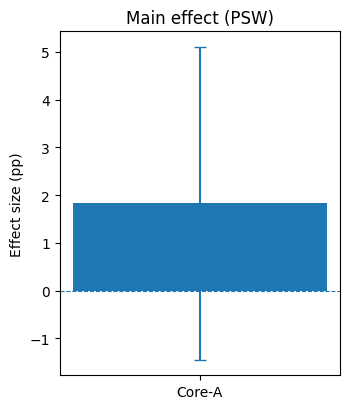

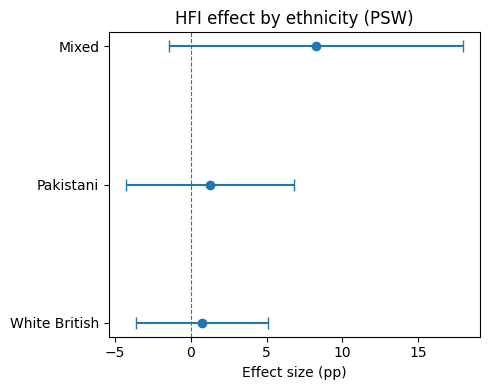

In [49]:
import matplotlib.pyplot as plt

# Figure 1: Core-A
fig, ax = plt.subplots(figsize=(3.6,4.2))
ax.bar(0, d_coreA)
ax.errorbar(0, d_coreA, yerr=[[d_coreA-ci_coreA[0]],[ci_coreA[1]-d_coreA]], fmt='none', capsize=4)
ax.axhline(0, ls='--', lw=0.8); ax.set_xticks([0]); ax.set_xticklabels(["Core-A"])
ax.set_ylabel("Effect size (pp)"); ax.set_title("Main effect (PSW)")
plt.tight_layout(); plt.show()

# Figure 2: Core-B
fig, ax = plt.subplots(figsize=(5,4))
ax.errorbar(coreB_by_eth["Δ (pp)"], coreB_by_eth["Ethnicity"],
            xerr=[coreB_by_eth["Δ (pp)"]-coreB_by_eth["95% CI lower"],
                  coreB_by_eth["95% CI upper"]-coreB_by_eth["Δ (pp)"]],
            fmt='o', capsize=4)
ax.axvline(0, ls='--', lw=0.8); ax.set_xlabel("Effect size (pp)")
ax.set_title("HFI effect by ethnicity (PSW)")
plt.tight_layout(); plt.show()


# 8) 主结果表（Table 2，一页汇总）

In [50]:
table2 = pd.DataFrame([
    ["Core-A (PSW, adj. demographics)", d_coreA,  ci_coreA[0],  ci_coreA[1]],
    ["Core-B: White British",          *coreB_by_eth.set_index("Ethnicity").loc["White British", ["Δ (pp)","95% CI lower","95% CI upper"]].tolist()],
    ["Core-B: Pakistani",              *coreB_by_eth.set_index("Ethnicity").loc["Pakistani",     ["Δ (pp)","95% CI lower","95% CI upper"]].tolist()],
    ["Core-B: Mixed",                  *coreB_by_eth.set_index("Ethnicity").loc["Mixed",         ["Δ (pp)","95% CI lower","95% CI upper"]].tolist()],
    ["Sens-SES (PSW + SES)",            d_ses,    ci_ses[0],   ci_ses[1]]
], columns=["Model","Δ (pp)","95% CI lower","95% CI upper"]).round(2)

table2["Effect size (pp) [95% CI]"] = table2.apply(lambda r: pretty_ci(r["Δ (pp)"], [r["95% CI lower"], r["95% CI upper"]]), axis=1)
table2_display = table2[["Model","Effect size (pp) [95% CI]"]]
table2_display


,Model,Effect size (pp) [95% CI]
0,"Core-A (PSW, adj. demographics)","1.83 (-1.45, 5.10)"
1,Core-B: White British,"0.77 (-3.58, 5.11)"
2,Core-B: Pakistani,"1.29 (-4.26, 6.84)"
3,Core-B: Mixed,"8.27 (-1.40, 17.94)"
4,Sens-SES (PSW + SES),"3.42 (-0.67, 7.50)"
